In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

## Table for data entries and abbreviations

#### Batting Data: G AB R H 2B 3B HR RBI BB IBB SO HBP SH SF XI ROE GDP SB CS AVG OBP SLG HAND

0: G: Games, total game played <br/>
1: AB: At bat, Total times at bat <br/>
2: R: Runs, total runs scored <br/>
3: H: Hits, total fair play hits <br/>
4: 2B: Double, reaching 2nd base from batting <br/>
5: 3B: Triple, reaching 3rd base from batting <br/>
6: HR: Home run, scoring straight from batting (includes in field home runs) <br/>
7: RBI: Runs batted in, total runs from this player's at bat <br/>
8: BB: Walks, total times walked (includes intentional walks) <br/>
9: IBB: Intentional Walk, intentionally walking batter to first base <br/>
10: SO: Strike out, total times struck out at base <br/>
11: HBP: Hit by pitch, total times <br/>
12: SH: Sacrifice bunt, bunt resulting in the batter being out but advances another runner <br/>
13: SF: Sacrifice fly, fly ball resulting in the batter being out but advances another runner <br/>
14: XI: ?, (almost all players have 0 for this statistic) <br/>
15: ROE: Reached on error, total times on base due to an error <br/>
16: GDP: Grounded into double play <br/>
17: SB: Stolen base, total bases stolen <br/>
18: CS: Caught stealing, Total times getting out when stealing.<br/>
19: AVG: Batting average, (total hits / total at bats) <br/>
20: OBP: On base percentage, (total times on base / total at bats) <br/>
21: SLG: Slugging percentage, bases per at bat ((1B + 2*2B + 3*3B + 4*HR) / AB) <br/>
22: HAND: Handedness, batting hand (1 = right, -1 = left) <br/>



#### Pitching Data: G GS CG SHO GF SV IP H BFP HR R ER BB IB SO SH SF WP HBP BK 2B 3B GDP ROE W L ERA RS PW HAND

0: G: Games played, total games played <br/>
1: GS: Games Started, threw the first pitch <br/>
2: CG: Complete game, pitched for the entire game <br/>
3: SHO: Shutout, pitches entire game without opposition scoring <br/>
4: GF: Games Finished, threw the last pitch (not counted if there was only 1 pitcher for the game) <br/>
5: SV: save, relief pitcher resulting in a win under certain conditions, https://www.mlb.com/glossary/standard-stats/save <br/>
6: IP: Innings pitched, total innings pitched (can be partial) <br/>
7: H: Hits, total hits allowed <br/>
8: BFP: Total batters face, total batters at plate when pitching <br/>
9: HR: Home runs allowed <br/>
10: R: Runs allowed?, total runs allowed <br/>
11: ER: Earned Run, total runs scored by the opposition due to the pitcher <br/>
12: BB: Walk, total walks <br/>
13: IB: Intentional walk? <br/>
14: SO: Strikeout, total batters struck out <br/>
15: SH: Sacrifice bunt, bunt resulting in the batter being out but advances another runner <br/>
16: SF: Sacrifice fly, fly ball resulting in the batter being out but advances another runner <br/>
17: WP: Wild pitches, pitch out of range for the catcher causing a runner to advance <br/>
18: HBP: Hit by pitch?, times batter is hit by a pitch <br/>
19: BK: Balk, number of illegal actions <br/>
20: 2B: Doubles allowed <br/>
21: 3B: Triples allowed <br/>
22: GDP: Grounded double plays? <br/>
23: ROE: Reached on error?, number of batters on base due to an error <br/>
24: W: Win, pitched while their team took the team and won the game <br/>
25: L: Loss, pitched while their team lost the lead and lost the game <br/>
26: ERA: Earned run average, (allowed runs * 9 / innings pitched ) <br/>
27: RS: Run support?, average opposition score (per game, not per inning) <br/>
28: PW: Total player rating, linear weighting of multiple statistics, https://en.wikipedia.org/wiki/Total_player_rating <br/>
29: HAND: Handedness, Pitching hand (1 = right, -1 = left) <br/>

In [2]:
def getDataFromFile(fileName, pitchingDataList, battingDataList):
    fileData=np.loadtxt(fileName, delimiter=',') 
    [N,dim]=np.shape(fileData) #set up matrix from file
    
    fileX = np.zeros((N, dim))
    dataY = np.zeros((N))
    
    fileX = fileData[:, 0:dim - 1] #remove output from the x array
    dataY[:] = fileData[:, dim - 1]
    
    dataX = np.zeros((N, 2*len(pitchingDataList) + 18*len(battingDataList)))
    dataXIndex = 0
    for i in pitchingDataList: #add data for home pitcher
        dataX[:,dataXIndex] = fileX[:,i]
        dataXIndex = dataXIndex + 1
    for i in range(9): #add data for home batters
        for j in battingDataList:
            dataX[:,dataXIndex] = fileX[:,(30 + 23*i + j)]
            dataXIndex = dataXIndex + 1
    for i in pitchingDataList: #add data for away pitcher
        dataX[:,dataXIndex] = fileX[:,(30 + 23*9 + i)]
        dataXIndex = dataXIndex + 1
    for i in range(9): #add data for away batters
        for j in battingDataList:
            dataX[:,dataXIndex] = fileX[:,(2*30 + 23*(9+i) + j)]
            dataXIndex = dataXIndex + 1
    
    return dataX, dataY

In [3]:
def getMeanAndStd(data): #get the mean and standard deviation of data columns
    means = [] #mean for each column
    stds = [] #standard deviation for each column
    for i in range(np.shape(data)[1]):
        mean = sum(data[:,i]) / len(data) 
        means.append(mean)
        stds.append( np.sqrt( sum((mean - data[:,i])**2)/len(data)) )
    return means, stds

def applyMeanAndStd(data, means, stds):
    newData = data
    for i in range(np.shape(newData)[1]):
        newData[:,i] = (data[:,i] - means[i])/stds[i] #normalize so that mean = 0, std = 1
    return newData

In [4]:
def structureGameData(gameData, batSize, pitSize): #take a single game and break into 2 pitching lists and 18 batting lists
    index = 0
    game = []
    game.append(gameData[index : index + pitSize]) #add home pitcher
    index = index + pitSize
    for i in range(9): #add home batters
        game.append(gameData[index : index + batSize])
        index = index + batSize
    game.append(gameData[index : index + pitSize]) #add away pitcher
    index = index + pitSize
    for i in range(9): #add away batters
        game.append(gameData[index : index + batSize])
        index = index + batSize
    
    return game

# WARNING: this function is specific to the current data lists, if the list changes the function should as well
def reformatGameData(games, batData, pitData):
    newGames = np.zeros((len(games), np.shape(games)[1] - 1*20)) #drop 20 per entry since we remove at bats and inning pitched
    
    pitSize = len(pitData)
    batSize = len(batData)

    for gameNum in range(len(games)):
        game = games[gameNum]
        gameStruct = structureGameData(game, batSize, pitSize)
        
        for batter in range(1 + 0, 1 + 9): #for each home batter
            for i in range(1, 10): #all data points except: at bats, bat avr%, hand will be divided by the # of at bats
                if(gameStruct[batter][0] != 0):
                    gameStruct[batter][i] = gameStruct[batter][i] / gameStruct[batter][0]
        for batter in range(11 + 0, 11 + 9): #for each away batter
            for i in range(1, 10): #all data points except: at bats, bat avr%, hand will be divided by the # of at bats
                if(gameStruct[batter][0] != 0):
                    gameStruct[batter][i] = gameStruct[batter][i] / gameStruct[batter][0]
                
        for i in range(1,7): #for home and away pitcher
            if(gameStruct[0][0] != 0):
                gameStruct[0][i] = gameStruct[0][i] / gameStruct[0][0]
            if(gameStruct[10][0] != 0):
                gameStruct[10][i] = gameStruct[10][i] / gameStruct[10][0]
        
        for i in range(len(gameStruct)): #throw away the first element of each list (either at bats, or innings pitched)
            gameStruct[i] = gameStruct[i][1:]
        flatGameStruct = []
        for elem in gameStruct: #flatten out list of lists
            for elem2 in elem: #list elements of list
                flatGameStruct.append(elem2)
        
        newGames[gameNum] = np.asarray(flatGameStruct) #flatten out since gameStruct is a list of lists
    return newGames
    

In [6]:
trainFileName = "F:\\Users\\Daniel\\Machine Learning Work\\Baseball work\\ML Data\\train.txt"
#valFileName = "F:\\Users\\Daniel\\Machine Learning Work\\Baseball work\\ML Data\\val.txt"
testFileName = "F:\\Users\\Daniel\\Machine Learning Work\\Baseball work\\ML Data\\test.txt"

batDataList = [1, 3, 4, 5, 6, 7, 9, 10, 17, 18, 19, 22] 
# at bats, hits, doubles, triples, home runs, rbi, intentional walks, strike outs, stolen bases, 
#...times caught stealing, batting avr %, handedness

#batDataList = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22] #all parameters

pitDataList = [6, 7, 20, 21, 9, 10, 14, 29] 
#innings pitched, hits allowed, doubles allowed, triples allowed, home runs allowed, runs allowed, strikeouts, handedness
#pitDataList = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29] #all parameters

trainX, trainY = getDataFromFile(trainFileName, pitDataList, batDataList) # ~ 32000 examples
#valX, valY = getDataFromFile(valFileName, pitDataList, batDataList) #8000 examples
testX, testY = getDataFromFile(testFileName, pitDataList, batDataList)

In [7]:
#reformat data
trainX = reformatGameData(trainX, batDataList, pitDataList)
#valX = reformatGameData(valX, batDataList, pitDataList)
testX = reformatGameData(testX, batDataList, pitDataList)

In [8]:
#normalize the data
dataMeans, dataStds = getMeanAndStd(trainX)
trainX = applyMeanAndStd(trainX, dataMeans, dataStds)
#valX = applyMeanAndStd(valX, dataMeans, dataStds)
testX = applyMeanAndStd(testX, dataMeans, dataStds)

In [19]:
def runModel(trainX, trainY, testX, testY, model, epochCount): #run and graph model results
    #compile the model
    model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    historyData = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=epochCount, verbose = 1)
    eIn = historyData.history["accuracy"]
    eOut = historyData.history["val_accuracy"]
    
    for i in range(len(eIn)):
        eIn[i] = 1-eIn[i]
    for i in range(len(eOut)):
        eOut[i] = 1-eOut[i]

    print('Train error:', eIn[-1])
    print('Test error: ', eOut[-1])
    
    #return error data to be plot later
    return eIn, eOut

Epoch 1/1000
1018/1018 [==============================] - 4s 3ms/step - loss: 0.9863 - accuracy: 0.5519 - val_loss: 0.6994 - val_accuracy: 0.5616
Epoch 2/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6972 - accuracy: 0.5575 - val_loss: 0.6904 - val_accuracy: 0.5698
Epoch 3/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6900 - accuracy: 0.5723 - val_loss: 0.6898 - val_accuracy: 0.56840 - accuracy: 0.57
Epoch 4/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6874 - accuracy: 0.5786 - val_loss: 0.6901 - val_accuracy: 0.5691
Epoch 5/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6858 - accuracy: 0.5776 - val_loss: 0.6888 - val_accuracy: 0.5713
Epoch 6/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6841 - accuracy: 0.5797 - val_loss: 0.6898 - val_accuracy: 0.5625
Epoch 7/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6832 - accuracy: 0.5845 - 

1018/1018 [==============================] - 3s 3ms/step - loss: 0.6723 - accuracy: 0.6194 - val_loss: 0.7019 - val_accuracy: 0.5596
Epoch 57/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6700 - accuracy: 0.6229 - val_loss: 0.7034 - val_accuracy: 0.5594
Epoch 58/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6747 - accuracy: 0.6163 - val_loss: 0.7068 - val_accuracy: 0.5471
Epoch 59/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6744 - accuracy: 0.6149 - val_loss: 0.7030 - val_accuracy: 0.5608
Epoch 60/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6729 - accuracy: 0.6189 - val_loss: 0.7035 - val_accuracy: 0.5585
Epoch 61/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6731 - accuracy: 0.6159 - val_loss: 0.7037 - val_accuracy: 0.5619
Epoch 62/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6747 - accuracy: 0.6178 - val_loss: 0.7053 - val_ac

Epoch 112/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6706 - accuracy: 0.6246 - val_loss: 0.7082 - val_accuracy: 0.5599
Epoch 113/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6705 - accuracy: 0.6251 - val_loss: 0.7088 - val_accuracy: 0.5611oss:
Epoch 114/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6705 - accuracy: 0.6224 - val_loss: 0.7090 - val_accuracy: 0.5543
Epoch 115/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6724 - accuracy: 0.6179 - val_loss: 0.7099 - val_accuracy: 0.5544
Epoch 116/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6728 - accuracy: 0.6234 - val_loss: 0.7112 - val_accuracy: 0.5523
Epoch 117/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6731 - accuracy: 0.6200 - val_loss: 0.7125 - val_accuracy: 0.5500
Epoch 118/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6716 - accuracy: 0.6218 - 

1018/1018 [==============================] - 3s 3ms/step - loss: 0.6681 - accuracy: 0.6344 - val_loss: 0.7149 - val_accuracy: 0.5475
Epoch 223/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6704 - accuracy: 0.6312 - val_loss: 0.7166 - val_accuracy: 0.5415
Epoch 224/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6714 - accuracy: 0.6256 - val_loss: 0.7151 - val_accuracy: 0.5435
Epoch 225/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6701 - accuracy: 0.6322 - val_loss: 0.7147 - val_accuracy: 0.5471
Epoch 226/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6697 - accuracy: 0.6285 - val_loss: 0.7113 - val_accuracy: 0.5521
Epoch 227/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6697 - accuracy: 0.6279 - val_loss: 0.7176 - val_accuracy: 0.5409
Epoch 228/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6661 - accuracy: 0.6373 - val_loss: 0.7140 - 

Epoch 277/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6678 - accuracy: 0.6333 - val_loss: 0.7119 - val_accuracy: 0.5435
Epoch 278/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6676 - accuracy: 0.6335 - val_loss: 0.7158 - val_accuracy: 0.5441
Epoch 279/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6707 - accuracy: 0.6275 - val_loss: 0.7141 - val_accuracy: 0.5497
Epoch 280/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6707 - accuracy: 0.6286 - val_loss: 0.7164 - val_accuracy: 0.5434
Epoch 281/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6722 - accuracy: 0.6226 - val_loss: 0.7165 - val_accuracy: 0.5429 loss: 0.6721 - accuracy - ETA: 1s - loss: 0.6721 
Epoch 282/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6706 - accuracy: 0.6281 - val_loss: 0.7156 - val_accuracy: 0.5450
Epoch 283/1000
1018/1018 [==============================] - 4s

Epoch 332/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6682 - accuracy: 0.6320 - val_loss: 0.7150 - val_accuracy: 0.5480
Epoch 333/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6686 - accuracy: 0.6326 - val_loss: 0.7161 - val_accuracy: 0.5403
Epoch 334/1000
1018/1018 [==============================] - 3s 2ms/step - loss: 0.6675 - accuracy: 0.6354 - val_loss: 0.7161 - val_accuracy: 0.5502
Epoch 335/1000
1018/1018 [==============================] - 3s 2ms/step - loss: 0.6686 - accuracy: 0.6304 - val_loss: 0.7176 - val_accuracy: 0.5495
Epoch 336/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6695 - accuracy: 0.6281 - val_loss: 0.7168 - val_accuracy: 0.5435
Epoch 337/1000
1018/1018 [==============================] - 3s 2ms/step - loss: 0.6668 - accuracy: 0.6358 - val_loss: 0.7169 - val_accuracy: 0.5412
Epoch 338/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6698 - accuracy: 0.6325 - val_

1018/1018 [==============================] - 3s 2ms/step - loss: 0.6689 - accuracy: 0.6339 - val_loss: 0.7181 - val_accuracy: 0.5378
Epoch 443/1000
1018/1018 [==============================] - 3s 2ms/step - loss: 0.6717 - accuracy: 0.6290 - val_loss: 0.7188 - val_accuracy: 0.5355
Epoch 444/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6671 - accuracy: 0.6347 - val_loss: 0.7158 - val_accuracy: 0.5450
Epoch 445/1000
1018/1018 [==============================] - 3s 2ms/step - loss: 0.6691 - accuracy: 0.6359 - val_loss: 0.7165 - val_accuracy: 0.5452
Epoch 446/1000
1018/1018 [==============================] - 3s 2ms/step - loss: 0.6677 - accuracy: 0.6344 - val_loss: 0.7164 - val_accuracy: 0.5434
Epoch 447/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6698 - accuracy: 0.6314 - val_loss: 0.7157 - val_accuracy: 0.5441
Epoch 448/1000
1018/1018 [==============================] - 3s 2ms/step - loss: 0.6689 - accuracy: 0.6353 - val_loss: 0.7154 - 

1018/1018 [==============================] - 3s 3ms/step - loss: 0.6707 - accuracy: 0.6312 - val_loss: 0.7160 - val_accuracy: 0.5470
Epoch 552/1000
1018/1018 [==============================] - 3s 2ms/step - loss: 0.6689 - accuracy: 0.6350 - val_loss: 0.7163 - val_accuracy: 0.5480
Epoch 553/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6688 - accuracy: 0.6325 - val_loss: 0.7184 - val_accuracy: 0.5440
Epoch 554/1000
1018/1018 [==============================] - 3s 2ms/step - loss: 0.6689 - accuracy: 0.6355 - val_loss: 0.7173 - val_accuracy: 0.5419
Epoch 555/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6681 - accuracy: 0.6343 - val_loss: 0.7167 - val_accuracy: 0.5476
Epoch 556/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6694 - accuracy: 0.6351 - val_loss: 0.7197 - val_accuracy: 0.5411
Epoch 557/1000
1018/1018 [==============================] - 3s 2ms/step - loss: 0.6673 - accuracy: 0.6333 - val_loss: 0.7162 - 

1018/1018 [==============================] - 3s 2ms/step - loss: 0.6707 - accuracy: 0.6312 - val_loss: 0.7172 - val_accuracy: 0.5465
Epoch 661/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6678 - accuracy: 0.6393 - val_loss: 0.7164 - val_accuracy: 0.5466
Epoch 662/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6684 - accuracy: 0.6353 - val_loss: 0.7171 - val_accuracy: 0.5436
Epoch 663/1000
1018/1018 [==============================] - 3s 2ms/step - loss: 0.6684 - accuracy: 0.6388 - val_loss: 0.7159 - val_accuracy: 0.5489
Epoch 664/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6663 - accuracy: 0.6410 - val_loss: 0.7150 - val_accuracy: 0.5443.6659 - accuracy
Epoch 665/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6683 - accuracy: 0.6369 - val_loss: 0.7182 - val_accuracy: 0.5391
Epoch 666/1000
1018/1018 [==============================] - 3s 2ms/step - loss: 0.6674 - accuracy: 0.6352 - val

1018/1018 [==============================] - 3s 3ms/step - loss: 0.6683 - accuracy: 0.6354 - val_loss: 0.7163 - val_accuracy: 0.5396682 - accuracy: 0.
Epoch 771/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6712 - accuracy: 0.6314 - val_loss: 0.7220 - val_accuracy: 0.5359
Epoch 772/1000
1018/1018 [==============================] - 3s 2ms/step - loss: 0.6674 - accuracy: 0.6358 - val_loss: 0.7178 - val_accuracy: 0.5425
Epoch 773/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6680 - accuracy: 0.6362 - val_loss: 0.7181 - val_accuracy: 0.5458
Epoch 774/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6699 - accuracy: 0.6332 - val_loss: 0.7201 - val_accuracy: 0.5399
Epoch 775/1000
1018/1018 [==============================] - 3s 2ms/step - loss: 0.6706 - accuracy: 0.6304 - val_loss: 0.7183 - val_accuracy: 0.5455
Epoch 776/1000
1018/1018 [==============================] - 3s 2ms/step - loss: 0.6709 - accuracy: 0.6276 - v

Epoch 825/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6667 - accuracy: 0.6386 - val_loss: 0.7176 - val_accuracy: 0.5456
Epoch 826/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6680 - accuracy: 0.6351 - val_loss: 0.7183 - val_accuracy: 0.5425
Epoch 827/1000
1018/1018 [==============================] - 3s 2ms/step - loss: 0.6707 - accuracy: 0.6345 - val_loss: 0.7186 - val_accuracy: 0.5450
Epoch 828/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6683 - accuracy: 0.6336 - val_loss: 0.7181 - val_accuracy: 0.5439
Epoch 829/1000
1018/1018 [==============================] - 3s 2ms/step - loss: 0.6688 - accuracy: 0.6381 - val_loss: 0.7168 - val_accuracy: 0.5468
Epoch 830/1000
1018/1018 [==============================] - 3s 2ms/step - loss: 0.6699 - accuracy: 0.6341 - val_loss: 0.7214 - val_accuracy: 0.5454
Epoch 831/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6665 - accuracy: 0.6407 - val_

1018/1018 [==============================] - 3s 2ms/step - loss: 0.6676 - accuracy: 0.6386 - val_loss: 0.7215 - val_accuracy: 0.5425
Epoch 936/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6687 - accuracy: 0.6362 - val_loss: 0.7209 - val_accuracy: 0.5391
Epoch 937/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6675 - accuracy: 0.6387 - val_loss: 0.7183 - val_accuracy: 0.5405671 - accu
Epoch 938/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6696 - accuracy: 0.6335 - val_loss: 0.7197 - val_accuracy: 0.5434
Epoch 939/1000
1018/1018 [==============================] - 3s 2ms/step - loss: 0.6645 - accuracy: 0.6417 - val_loss: 0.7195 - val_accuracy: 0.5390
Epoch 940/1000
1018/1018 [==============================] - 3s 2ms/step - loss: 0.6681 - accuracy: 0.6404 - val_loss: 0.7206 - val_accuracy: 0.5409
Epoch 941/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6687 - accuracy: 0.6338 - val_loss:

1018/1018 [==============================] - 3s 2ms/step - loss: 0.6680 - accuracy: 0.6377 - val_loss: 0.7194 - val_accuracy: 0.5446
Epoch 991/1000
1018/1018 [==============================] - 3s 2ms/step - loss: 0.6678 - accuracy: 0.6341 - val_loss: 0.7194 - val_accuracy: 0.5447
Epoch 992/1000
1018/1018 [==============================] - 3s 2ms/step - loss: 0.6682 - accuracy: 0.6360 - val_loss: 0.7194 - val_accuracy: 0.5419
Epoch 993/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6689 - accuracy: 0.6376 - val_loss: 0.7241 - val_accuracy: 0.5357
Epoch 994/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6653 - accuracy: 0.6409 - val_loss: 0.7203 - val_accuracy: 0.5409
Epoch 995/1000
1018/1018 [==============================] - 3s 2ms/step - loss: 0.6705 - accuracy: 0.6319 - val_loss: 0.7210 - val_accuracy: 0.5446
Epoch 996/1000
1018/1018 [==============================] - 3s 3ms/step - loss: 0.6705 - accuracy: 0.6330 - val_loss: 0.7236 - 

[]

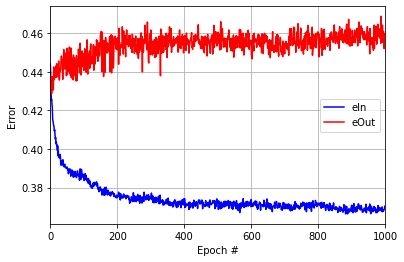

In [21]:
regParam = keras.regularizers.l2(.001) #create regularization parameter
modelInter = tf.keras.Sequential([
        keras.layers.Dense(units=np.shape(trainX)[1], activation='relu', kernel_regularizer=regParam),
        keras.layers.Dense(units=125, activation='relu', kernel_regularizer=regParam),
        keras.layers.Dense(units=100, activation='relu', kernel_regularizer=regParam),
        keras.layers.Dense(units=75, activation='relu', kernel_regularizer=regParam),
        keras.layers.Dense(units=50, activation='relu', kernel_regularizer=regParam),
        keras.layers.Dense(units=25, activation='relu', kernel_regularizer=regParam),
        keras.layers.Dense(units=1, activation='sigmoid', kernel_regularizer=regParam)
    ])

epochs = 1000
eIn, eOut = runModel(trainX, trainY, testX, testY, modelInter, epochs)

fig, ax=plt.subplots()
ax.plot(eIn,'-b')
ax.plot(eOut,'-r')
ax.set_xlabel('Epoch #')
ax.set_ylabel('Error')
ax.grid()
ax.legend(['eIn', 'eOut'])
ax.axes.set_xlim([0,epochs])
ax.plot()

In [86]:
#print accuracy if guessing the home team always wins

print("in sample accuracy:", 1-eIn[-1])
print("val sample accuracy:", 1-eOut[-1])
print("simple guess: ", sum(np.ones(np.shape(trainY)) == trainY) / len(trainY))

in sample accuracy: 0.575917661190033
val sample accuracy: 0.5665000081062317
simple guess:  0.5393027184764245


In [88]:
testFileName = "F:\\Users\\Daniel\\Machine Learning Work\\Baseball work\\ML Data\\test.txt"
testX, testY = getDataFromFile(testFileName, pitDataList, batDataList) #8000 examples
testX = reformatGameData(testX, batDataList, pitDataList)
testX = applyMeanAndStd(testX, dataMeans, dataStds)

In [108]:
testAcc = modelInter.evaluate(testX, testY)[1]
print(testAcc)

250/250 [==============================] - 0s 1ms/step - loss: 0.6833 - accuracy: 0.5610
0.5609999895095825


In [110]:
#save model, from tensorflow documentation, https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model
!mkdir saved_model
modelInter.save('saved_model/myModelFinal')

A subdirectory or file saved_model already exists.
Error occurred while processing: saved_model.


INFO:tensorflow:Assets written to: saved_model/myModelFinal\assets


In [111]:
#load model, also from tensorflow documentation
new_model = tf.keras.models.load_model('saved_model/myModelFinal')